In [17]:
## Started overall formatting here. We may want to separate functions into different files so it is easier to work on

### Imports
import numpy as np
import matplotlib.pyplot as plt
from numba import njit  
import sys
from numpy.polynomial.legendre import leggauss


### Arguments
N = 128

### Funcitons
@njit
def gauss_Integral(x_l,w,a1,b1,u):
    # Calculate integral with gauss points x between a1 and b1
    # x: Gauss Points
    # w: Gauss Weights
    # a1: Lower Bound
    # b1: Upper Bound
    # u: Function to Integrate

    N = len(u)
    sum = 0.

    ## PUT SOMETHING HERE - Use trapezoidal_Integral for now

    return sum

@njit
def trapezoidal_Integral(r,u):
    # Calculate integral with gauss points x between a1 and b1
    # r: Radius
    # u: Function to Integrate

    N = len(u)
    sum = 0.
    for i in range(1,N):
        sum += np.pi*(r[i]**2-r[i-1]**2)*(u[i]+u[i-1])/2
    return sum


## This function will contain bulk of solving code
@njit
def delta_step(delta, b, dt, V0):
    g = 9.81
    nu = 1

    N = len(delta)
    xi = np.linspace(0, 1, N)
    dxi = xi[1]-xi[0]

    # Calculate delta(xi) at next time step
    delta_new = np.zeros(N)

    # Inner Points
    for i in range(1,N-1):
        delta_new[i] = delta[i] + g*dt/3/nu*(delta[i]**3/b**2 * ((delta[i-1]-2*delta[i]+delta[i+1])/dxi**2 + 1/xi[i]*(delta[i+1]-delta[i-1])/2/dxi) + 3*delta[i]**2/b**2 * (delta[i+1]-delta[i-1])/2/dxi)

    # Boundary Points
    delta_new[0] = delta_new[1]
    delta_new[-1] = 0
    
    # Solve for b_new through integral condition using shooting method
    err = 1
    b_range = np.array((b, 2*b))

    while err > 1e-6:
    #for aaa in range(10000):
        b_guess = np.mean(b_range)
        V_new = trapezoidal_Integral(b_guess*xi, delta_new)

        if V_new < V0:
            b_range[0] = b_guess
        else:
            b_range[1] = b_guess

        err = np.abs(V_new-V0)

    b_new = b_guess

    return delta_new, b_new


### Main Script

# Initialize as a circular drop with radius b0 = 1
b0 = 1
delta = np.zeros((N))
xi = np.linspace(0, 1, N) # xi = r/b
for i in range(N):
    delta[i] = np.sqrt(b0**2 - xi[i]**2)

# Ensure BC's are met in initial condition
delta[-1] = 0 #(delta = 0 at xi = 1)
delta[1] = delta[0] # first derivative = 0 at BC (this is order 1 right now, may want to make better!)

# Calculate Initial Volume
p = 5
(x_l,w) = leggauss(p) # Find Gauss Points of Degree p
V0 = trapezoidal_Integral(b0*xi,delta)


## Run Time Stepping
dt = 0.00001
t = np.arange(0, 5, dt)

# Initialize Stored Values
delta_history = np.zeros((len(t), N)) # delta(t)
delta_history[0,:] = delta[:] # Initial Condition
V = np.zeros(len(t)) # Volume
b = np.zeros(len(t)) # Radius
b[0] = b0 # Initial Condition

for i in range(len(t)-1):
    # Calculate Current Volume
    V[i] = trapezoidal_Integral(b[i]*xi, delta_history[i,:])

    # Step
    delta_new, b_new = delta_step(delta_history[i,:], b[i], dt, V0)
    delta_history[i+1,:] = delta_new
    b[i+1] = b_new

## Plotting
#plt.figure()


In [14]:
V

array([2.09317093, 2.09317134, 2.09317188, ..., 2.09317162, 2.09317146,
       0.        ])

In [43]:
b

array([1.        , 1.00006676, 1.00013352, ..., 2.56590769, 2.56590799,
       2.5659083 ])

IndexError: index 1280000 is out of bounds for axis 0 with size 1000000

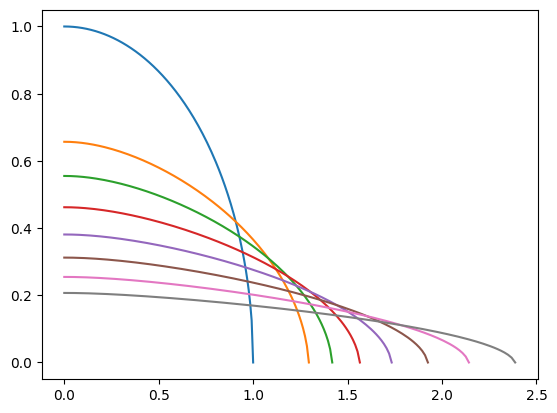

In [15]:
plt.figure()
for i in range(int(60/dt)):
    if i*dt % 0.1 == 0:
        plt.plot(xi*b[i],delta_history[i,:],label=('t = '+str(i*dt)))
plt.legend()
plt.axis('equal')
plt.xlabel('r')
plt.ylabel(r"$\delta(r,t)$")

IndexError: index 1280000 is out of bounds for axis 0 with size 1000000

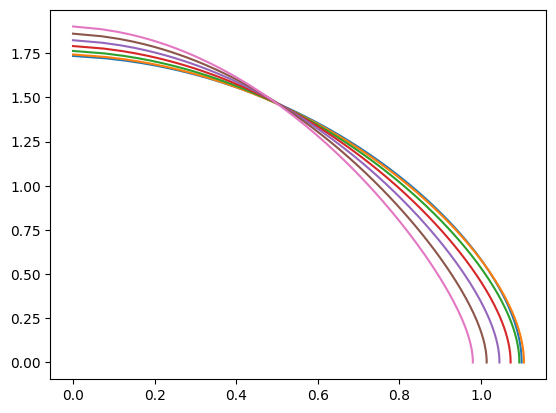

In [16]:
# Similarity Solution Plot
plt.figure()
C = 1
for i in range(int(60/dt)):
    if i*dt % .1 == 0 and i != 0:
        nu = xi*b[i] * (3*1*np.pi**3*C**3/(V0**3*9.81*i*dt))**(1/8)
        f = delta_history[i,:] / (3*V0*1/(16*np.pi*C*9.81*i*dt))**(1/4)

        #nu = (16*np.pi*9.81/V0/1)**(3/8)*(1/8/9.81)**(1/2)**(i*dt)**(-1/8)*xi*b[i]
        #f = delta_history[i,:] / (V0*1/16/np.pi/9.81)**(1/4) / (i*dt)**(1/4)
        
        plt.plot(f,nu,label=('t = '+str(i*dt)))
plt.legend()
plt.axis('equal')
plt.ylabel(r'$f(\nu)$')
plt.xlabel(r"$\nu$")

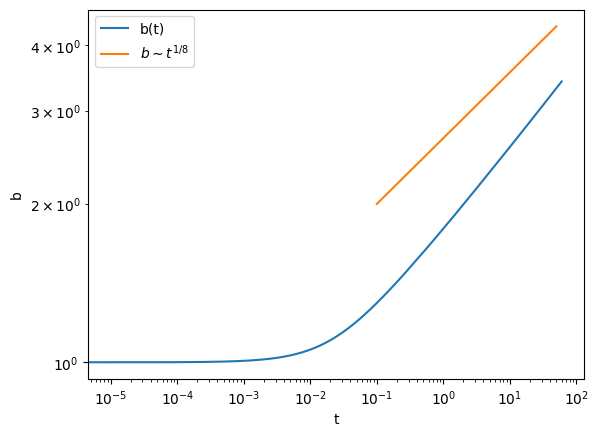

In [4]:
# b(t)
plt.figure()
plt.loglog(t, b,label='b(t)')
plt.loglog(np.array((0.1,50)),np.array((2,2*500**(1/8))),label=r'$b \sim t^{1/8}$')
plt.ylabel('b')
plt.xlabel('t')
plt.legend()

Text(0.5, 0, 't')

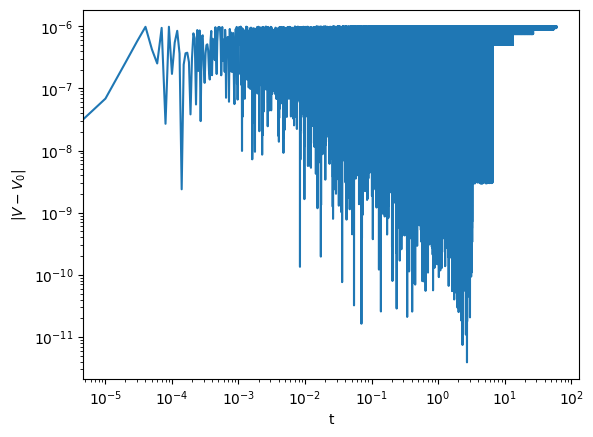

In [10]:
# V_err(t)
plt.figure()
plt.loglog(t[0:-2], np.abs(V[0:-2]-V0))
plt.ylabel(r'$|V-V_0|$')
plt.xlabel('t')
